<a href="https://colab.research.google.com/github/trucabrac/Lisek-AIMA-workshop/blob/main/My_OpenAI_CLIP_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image caption scoring with the OpenAI CLIP model

In this Colab I will verify the zero-shot performance of the OpenAI CLIP model (https://github.com/openai/CLIP) on random images.

I was inspired by two recent twitter posts to start toying around with CLIP: 
https://twitter.com/metasemantic/status/1349446585952989186
https://twitter.com/stanislavfort/status/1349394023010615296 

Original paper: **[Learning Transferable Visual Models From Natural Language Supervision](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language.pdf)**

Even more impressive (although no access as of yet 14-01-2021)
[DALL·E: Creating Images from Text](https://openai.com/blog/dall-e/)

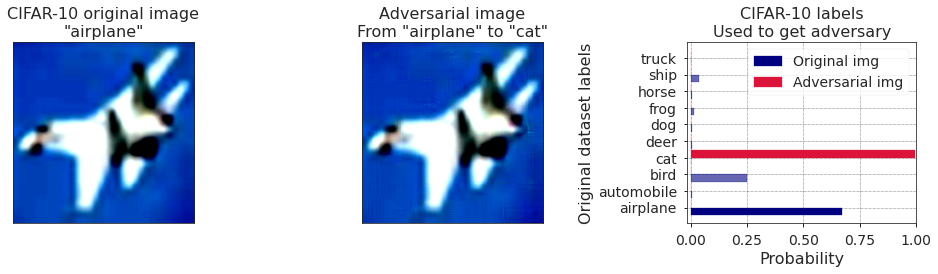

# Dependencies

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

import matplotlib.pyplot as plt
import os

CUDA version: 10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 24kB/s 
     |████████████████████████████████| 12.8MB 25.4MB/s 
     |████████████████████████████████| 71kB 4.4MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45613 sha256=4e5aa207820775a2ba3409f3d15dc6269559aa23f0033e391f1461a91ef43266
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
Torch version: 1.7.1+cu101


In [ ]:
# we'll need this function later to plot our predictions into a barchart format ;)
def make_plot_from_preds(orig_preds,class_labels,colors = ["navy"]):

  width = 0.45

  for i in range(orig_preds.shape[0]):
    v_orig = orig_preds[i]

    label1 = ""

    alpha_mod = 0.6
    alpha_orig = 0.6

    alpha_orig = 1.0
    label1 = "Original img"
    plt.fill_between([0,v_orig],[i-width,i-width],[i,i], color = colors[0],label = label1, alpha = alpha_orig)

  plt.yticks(range(len(class_labels)),class_labels,fontsize = 14)#, rotation = 45)

  plt.xticks(fontsize = 14)

  plt.xlabel("Probability",fontsize = 16)
  plt.ylabel("Original captions",fontsize = 16)
  plt.xlim([-0.015,1.0])

# Downloading OpenAI CLIP from GitHub

In [ ]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 9), reused 18 (delta 4), pack-reused 0
Unpacking objects: 100% (24/24), done.
/content/CLIP


# Can toy around already with new uploaded files

In [ ]:
# You'll get 1 image for free, the rest is up to you to decide
! wget https://github.com/Jordy-VL/jordy-vl.github.io/raw/master/assets/fish.jpg

--2021-01-14 11:26:17--  https://github.com/Jordy-VL/jordy-vl.github.io/raw/master/assets/fish.jpg
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Jordy-VL/jordy-vl.github.io/master/assets/fish.jpg [following]
--2021-01-14 11:26:17--  https://raw.githubusercontent.com/Jordy-VL/jordy-vl.github.io/master/assets/fish.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238121 (233K) [image/jpeg]
Saving to: ‘fish.jpg’

fish.jpg            100%[===================>] 232.54K  --.-KB/s    in 0.02s   

2021-01-14 11:26:18 (11.0 MB/s) - ‘fish.jpg’ saved [238121/238121]



In [ ]:
# IF you are not gonna upload, then press the square stop button, otherwise it might keep other cells from running
from google.colab import files
uploaded = files.upload()
# the files will end up in the CLIP folder, so no need for path checking in the next cell

In order to **switch to a new image**
* change variable "test_image" to the name of one of the images you uploaded
* change variable "possible captions" to any number of arbitrary strings

Run all 3 cells below again.

In [ ]:
test_image = "fish.jpg"
possible_captions = ["a fish", "a man", "two friends on a boat", "your worst nightmare", "a shark"]

try:
  assert(os.path.exists(test_image))
except AssertionError as e:
  print(f"You do not have {test_image}, are you sure you uploaded your own image?")

In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open(test_image)).unsqueeze(0).to(device)
text = clip.tokenize(possible_captions).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.02983 0.01895 0.5044  0.2039  0.1945  0.0484 ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], [])

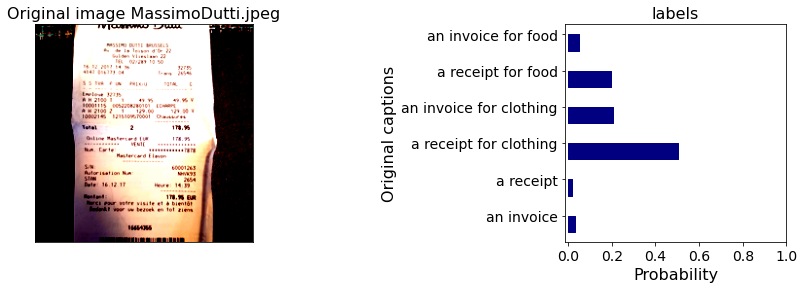

In [ ]:
plt.figure(figsize = (3*4.5,4))

plt.subplot(1,3,3)
plt.title("labels",fontsize = 16)
make_plot_from_preds(probs[0],possible_captions)
plt.ylabel("Original captions")

plt.subplot(1,3,1)
plt.title("Original image " + test_image,fontsize = 16)
plt.imshow(image[0].cpu().permute(1, 2, 0)) 
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])

In [ ]:
test_image = "MassimoDutti.jpeg"
possible_captions = ["an invoice", "a receipt", "a receipt for clothing", "an invoice for clothing",  "a receipt for food", "an invoice for food"]